In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from dataset import FacialKeypointsDataset
import cv2
from torch.utils.data import Dataset, DataLoader
import pandas as pd

import config
import utils

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import config
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.savefig(f"{config.OUTPUT_PATH}/val_epoch_{epoch}.png")
    plt.close()

In [4]:
def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact corrent and the faces align wiht the keypoint features. The plot 
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    plt.show()
    plt.close()

In [6]:
import torch
# constant paths
ROOT_PATH = './'
OUTPUT_PATH = './outputs'
# learning parameters
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.1
# show dataset keypoint plot
SHOW_DATASET_PLOT = True

In [7]:
class FaceKeypointDataset(Dataset):
    def __init__(self, samples, path):
        self.data = samples
        self.path = path
        self.resize = 224
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = cv2.imread(f"{self.path}/{self.data.iloc[index][0]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w, channel = image.shape
        # resize the image into `resize` defined above
        image = cv2.resize(image, (self.resize, self.resize))
        # again reshape to add grayscale channel format
        image = image / 255.0
        # transpose for getting the channel size to index 0
        image = np.transpose(image, (2, 0, 1))
        # get the keypoints
        keypoints = self.data.iloc[index][1:]
        keypoints = np.array(keypoints, dtype='float32')
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

In [10]:
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointDataset(training_samples, 
                                 "./training")
valid_data = FaceKeypointDataset(valid_samples, 
                                 "./training")
# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)
print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

Training sample instances: 3116
Validation sample instances: 346


In [11]:
# # whether to show dataset keypoint plots
# if SHOW_DATASET_PLOT:
#     dataset_keypoints_plot(valid_data)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import pretrainedmodels

class FaceKeypointResNet18(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(FaceKeypointResNet18, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet18'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet18'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(512, 136)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

In [12]:
from tqdm import tqdm
import matplotlib
matplotlib.style.use('ggplot')

In [13]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib
import config
import utils

In [14]:
# model 
model = FaceKeypointResNet18(pretrained=True, requires_grad=True).to(DEVICE)
# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmmothL1Loss ...
# ... or MSELoss
criterion = nn.SmoothL1Loss()

Training intermediate layer parameters...


In [16]:
# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(config.DEVICE), data['keypoints'].to(config.DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/counter
    return train_loss

In [17]:
# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(config.DEVICE), data['keypoints'].to(config.DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs
            if (epoch+1) % 1 == 0 and i == 0:
                utils.valid_keypoints_plot(image, outputs, keypoints, epoch)
        
    valid_loss = valid_running_loss/counter
    return valid_loss

In [18]:
import time

train_loss = []
val_loss = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)

    start_time = time.time()
    val_epoch_loss = validate(model, valid_loader, valid_data, epoch)
    end_time = time.time()
    
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f"Test time: {end_time - start_time}")

Epoch 1 of 30
Training


  0%|          | 0/97 [00:00<?, ?it/s]

98it [01:08,  1.42it/s]                        


Validating


11it [00:06,  1.80it/s]                        


Train Loss: 40.0861
Val Loss: 10.6164
Test time: 6.101433038711548
Epoch 2 of 30
Training


98it [00:23,  4.18it/s]                        


Validating


11it [00:02,  4.12it/s]                        


Train Loss: 7.4105
Val Loss: 8.5629
Test time: 2.6708791255950928
Epoch 3 of 30
Training


98it [00:23,  4.16it/s]                        


Validating


11it [00:02,  4.11it/s]                        


Train Loss: 6.3844
Val Loss: 6.7564
Test time: 2.68036150932312
Epoch 4 of 30
Training


98it [00:23,  4.16it/s]                        


Validating


11it [00:02,  4.02it/s]                        


Train Loss: 5.0180
Val Loss: 5.6414
Test time: 2.7410995960235596
Epoch 5 of 30
Training


98it [00:23,  4.15it/s]                        


Validating


11it [00:02,  3.99it/s]                        


Train Loss: 4.5242
Val Loss: 4.5451
Test time: 2.757174253463745
Epoch 6 of 30
Training


98it [00:23,  4.16it/s]                        


Validating


11it [00:02,  4.10it/s]                        


Train Loss: 4.1815
Val Loss: 4.9821
Test time: 2.68599271774292
Epoch 7 of 30
Training


98it [00:23,  4.20it/s]                        


Validating


11it [00:02,  4.21it/s]                        


Train Loss: 4.0366
Val Loss: 4.2652
Test time: 2.6167919635772705
Epoch 8 of 30
Training


98it [00:23,  4.19it/s]                        


Validating


11it [00:02,  4.15it/s]                        


Train Loss: 3.8569
Val Loss: 3.9343
Test time: 2.655203104019165
Epoch 9 of 30
Training


98it [00:23,  4.19it/s]                        


Validating


11it [00:02,  3.99it/s]                        


Train Loss: 3.5604
Val Loss: 4.1645
Test time: 2.7606704235076904
Epoch 10 of 30
Training


98it [00:23,  4.19it/s]                        


Validating


11it [00:02,  4.28it/s]                        


Train Loss: 3.2941
Val Loss: 3.5373
Test time: 2.5701181888580322
Epoch 11 of 30
Training


98it [00:23,  4.21it/s]                        


Validating


11it [00:02,  3.88it/s]                        


Train Loss: 3.2445
Val Loss: 3.3095
Test time: 2.841550350189209
Epoch 12 of 30
Training


98it [00:23,  4.18it/s]                        


Validating


11it [00:02,  4.01it/s]                        


Train Loss: 3.1527
Val Loss: 3.3466
Test time: 2.7428534030914307
Epoch 13 of 30
Training


98it [00:23,  4.18it/s]                        


Validating


11it [00:02,  4.05it/s]                        


Train Loss: 2.9844
Val Loss: 2.6694
Test time: 2.7194583415985107
Epoch 14 of 30
Training


98it [00:23,  4.12it/s]                        


Validating


11it [00:02,  4.08it/s]                        


Train Loss: 2.7228
Val Loss: 2.7199
Test time: 2.6972153186798096
Epoch 15 of 30
Training


98it [00:22,  4.26it/s]                        


Validating


11it [00:02,  4.21it/s]                        


Train Loss: 2.6945
Val Loss: 2.6181
Test time: 2.615805149078369
Epoch 16 of 30
Training


98it [00:22,  4.27it/s]                        


Validating


11it [00:02,  4.23it/s]                        


Train Loss: 2.4493
Val Loss: 2.2221
Test time: 2.60144305229187
Epoch 17 of 30
Training


98it [00:22,  4.28it/s]                        


Validating


11it [00:02,  4.38it/s]                        


Train Loss: 2.4662
Val Loss: 2.0776
Test time: 2.51640248298645
Epoch 18 of 30
Training


98it [00:22,  4.29it/s]                        


Validating


11it [00:02,  3.89it/s]                        


Train Loss: 2.2634
Val Loss: 2.3614
Test time: 2.827843427658081
Epoch 19 of 30
Training


98it [00:22,  4.28it/s]                        


Validating


11it [00:02,  4.32it/s]                        


Train Loss: 2.2831
Val Loss: 2.2409
Test time: 2.549985408782959
Epoch 20 of 30
Training


98it [00:22,  4.31it/s]                        


Validating


11it [00:02,  4.29it/s]                        


Train Loss: 2.2872
Val Loss: 2.4599
Test time: 2.5675501823425293
Epoch 21 of 30
Training


98it [00:19,  5.01it/s]                        


Validating


11it [00:02,  4.65it/s]                        


Train Loss: 2.0234
Val Loss: 2.4554
Test time: 2.3682937622070312
Epoch 22 of 30
Training


98it [00:19,  5.03it/s]                        


Validating


11it [00:02,  4.69it/s]                        


Train Loss: 2.1472
Val Loss: 1.8745
Test time: 2.350206136703491
Epoch 23 of 30
Training


98it [00:19,  5.05it/s]                        


Validating


11it [00:02,  4.53it/s]                        


Train Loss: 1.9585
Val Loss: 2.7683
Test time: 2.4327874183654785
Epoch 24 of 30
Training


98it [00:19,  5.03it/s]                        


Validating


11it [00:02,  4.67it/s]                        


Train Loss: 1.8398
Val Loss: 2.6815
Test time: 2.3564612865448
Epoch 25 of 30
Training


98it [00:19,  5.03it/s]                        


Validating


11it [00:02,  4.41it/s]                        


Train Loss: 1.8593
Val Loss: 2.0204
Test time: 2.496587038040161
Epoch 26 of 30
Training


98it [00:19,  5.03it/s]                        


Validating


11it [00:02,  4.82it/s]                        


Train Loss: 1.8634
Val Loss: 2.0074
Test time: 2.2844691276550293
Epoch 27 of 30
Training


98it [00:17,  5.62it/s]                        


Validating


11it [00:02,  4.58it/s]                        


Train Loss: 1.7761
Val Loss: 2.0419
Test time: 2.4055891036987305
Epoch 28 of 30
Training


98it [00:17,  5.63it/s]                        


Validating


11it [00:02,  5.03it/s]                        


Train Loss: 1.7701
Val Loss: 2.1737
Test time: 2.190263509750366
Epoch 29 of 30
Training


98it [00:17,  5.68it/s]                        


Validating


11it [00:02,  4.97it/s]                        


Train Loss: 1.6725
Val Loss: 1.7247
Test time: 2.215418815612793
Epoch 30 of 30
Training


98it [00:17,  5.64it/s]                        


Validating


11it [00:02,  5.19it/s]                        

Train Loss: 1.7444
Val Loss: 2.1238
Test time: 2.1227450370788574


# Task 1_3

In [21]:
import os

parent_folder = "/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy"
count = 0

path_list = []

for root, dirs, files in os.walk(parent_folder):
    for file in files:
        # print(os.path.join(root, file))
        count += 1
        path_list.append(os.path.join(root, file))

print(count)
print(path_list)

1774
['/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PublicTest_66233719.jpg', '/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PrivateTest_41871309.jpg', '/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PublicTest_3830494.jpg', '/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PrivateTest_64684639.jpg', '/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PublicTest_34451492.jpg', '/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PrivateTest_72320360.jpg', '/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PublicTest_72748939.jpg', '/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PublicTest_17071643.jpg', '/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PrivateTest_91362293.jpg', '/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PrivateTest_23955431.jpg', 

In [ ]:
class FaceKeypointDataset_modified(Dataset):
    def __init__(self, path):
        self.path = path
        self.resize = 224
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = cv2.imread(f"{self.path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w, channel = image.shape
        # resize the image into `resize` defined above
        image = cv2.resize(image, (self.resize, self.resize))
        # again reshape to add grayscale channel format
        image = image / 255.0
        # transpose for getting the channel size to index 0
        image = np.transpose(image, (2, 0, 1))
        
        
        return torch.tensor(image, dtype=torch.float)
            
        

In [27]:
model.load_state_dict(torch.load('/home/bhuiyan.shafique/Documents/CV701/Assignment_4/Facial-Keypoint-Detection/data/'))
model.eval()

path_list = ['/home/bhuiyan.shafique/Documents/CV701/Assignment_4/Facial-Keypoint-Detection/data/test/Charlie_Coles_21.jpg']

for var_path in path_list:
    image = cv2.imread(f"{var_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w, channel = image.shape
    # resize the image into `resize` defined above
    image = cv2.resize(image, (224, 224))
    # again reshape to add grayscale channel format
    image = image / 255.0
    # transpose for getting the channel size to index 0
    image = np.transpose(image, (2, 0, 1))
    
    
    image = torch.tensor(image, dtype=torch.float).to(config.DEVICE)

    outputs = model(torch.unsqueeze(image, 0))
    print(outputs.shape)
    print(outputs.view(68, 2).shape)
    break

print(outputs.shape)

torch.Size([1, 136])
torch.Size([68, 2])
torch.Size([1, 136])


In [17]:
import glob
import os
from torch.utils.data import Dataset
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import pandas as pd

torch.Size([68, 2])


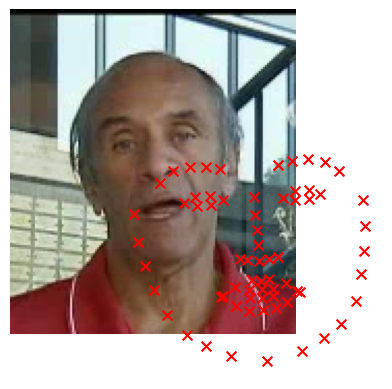

In [38]:
image = mpimg.imread('/home/bhuiyan.shafique/Documents/CV701/Assignment_4/Facial-Keypoint-Detection/data/test/Charlie_Coles_21.jpg')
plt.imshow(image)

outputs = outputs.reshape(68, 2)
outputs = outputs.detach().cpu()

print(outputs.shape)

for i, (x, y) in enumerate(outputs):
    plt.scatter(x, y, color='red', marker='x', s=50)
    # if i == 19:
    #   break

plt.axis('off')  # Optional: Turn off axis labels
plt.show()

# Template Matching

In [9]:
import cv2

In [15]:
model = FaceKeypointResNet18(pretrained=True, requires_grad=False).to(config.DEVICE)
checkpoint = torch.load('./outputs/model_18.pth', map_location='cpu')

# Get the model state dictionary
model_state_dict = model.state_dict()

# Filter out unnecessary keys
checkpoint = {k: v for k, v in checkpoint.items() if k in model_state_dict}

# Load the modified checkpoint
model.load_state_dict(checkpoint, strict=False)
model.eval()
# model.half()

Freezing intermediate layer parameters...


FaceKeypointResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [17]:
image_path = './Results/Task 1.3/U2.jpeg'
path_list = [image_path]
# path_list = ['/home/bhuiyan.shafique/Documents/CV701/Assignment_4/FER_2013/test/happy/PrivateTest_56410190.jpg']

for var_path in path_list:
    image = cv2.imread(f"{var_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    channel, orig_w, orig_h = image.shape
    # resize the image into `resize` defined above
    image = cv2.resize(image, (224, 224))
    # again reshape to add grayscale channel format
    image = image / 255.0
    # transpose for getting the channel size to index 0
    image = np.transpose(image, (2, 0, 1))
    image = torch.tensor(image, dtype=torch.float).to(config.DEVICE)

    outputs = model(torch.unsqueeze(image, 0))
    print(outputs.shape)
    print(outputs.view(68, 2).shape)
    
    break

print(outputs.shape)

image = cv2.imread(f"{var_path}")

# cv2.imshow('window_name', image) 
# cv2.waitKey(0) 
# cv2.destroyAllWindows() 

torch.Size([1, 136])
torch.Size([68, 2])
torch.Size([1, 136])


(224, 224, 3)
torch.Size([68, 2])


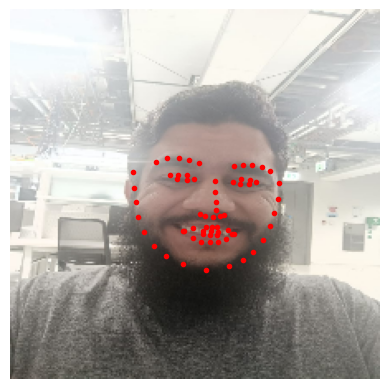

In [18]:
# image = mpimg.imread(image_path)
image = cv2.imread(f"{var_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
print(image.shape)
plt.imshow(image)
# outputs = model(image)

outputs = outputs.reshape(68, 2)
outputs = outputs.detach().cpu()

print(outputs.shape)

for i, (x, y) in enumerate(outputs):
    plt.plot(x, y, 'r.')
    # if i == 19:
    #   break

plt.axis('off')  # Optional: Turn off axis labels
plt.show()

In [19]:
# Positions of lips
upper_lip = [48, 49, 50, 51, 52, 53, 54, 61, 62, 63]
lower_lip = [55, 56, 57, 58, 59, 60, 64, 65, 66, 67]

lip = []
lip.extend(upper_lip)
lip.extend(lower_lip)



# For Mouth

######################


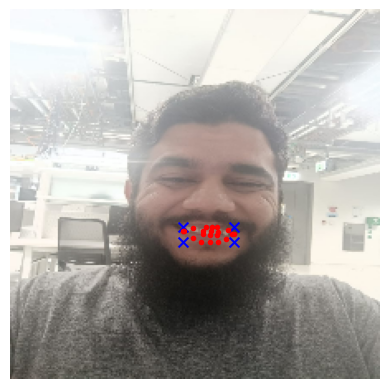

In [20]:
# index = 152
plt.imshow(image)

max_x = 0
min_x = 0
max_y = 0
min_y = 0

for i, ind in enumerate(lip):
    (x, y) = outputs[ind]
    if i == 0:
        max_x = x
        min_x = x
        max_y = y
        min_y = y

    if x > max_x:
        max_x = x
    if x < min_x:
        min_x = x
    if y > max_y:
        max_y = y
    if y < min_y:
        min_y = y
    
    plt.plot(x, y, 'r.')
    # plt.scatter(x, y, color='red', marker='x', s=50)
    # print(x)
    # print(y)

# for i, (x, y) in enumerate(dataset[index]['keypoints']):
#     plt.scatter(x, y, color='red', marker='x', s=50)
#     if i == 59:
#       break



print("######################")

# print(max_x)
# print(min_x)
# print(max_y)
# print(min_y)



plt.scatter(max_x, max_y, color='blue', marker='x', s=50)
plt.scatter(max_x, min_y, color='blue', marker='x', s=50)
plt.scatter(min_x, max_y, color='blue', marker='x', s=50)
plt.scatter(min_x, min_y, color='blue', marker='x', s=50)

plt.axis('off')  # Optional: Turn off axis labels
plt.show()


In [26]:
lips = image[ int(min_y-8) : int(max_y+8), int(min_x-20) : int(max_x+20), :]
plt.imsave('./Results/Pos-lips-Umair.jpg', lips)

(-0.5, 70.5, 24.5, -0.5)

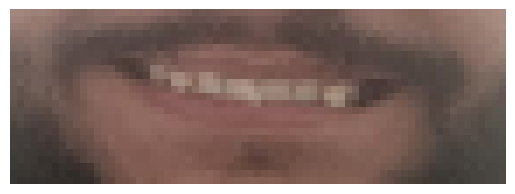

In [21]:
plt.imshow(image[ int(min_y-8) : int(max_y+8), int(min_x-20) : int(max_x+20), :])
plt.grid(False)
plt.axis('off')

In [22]:
img_mouth_seg = image[ int(min_y-5) : int(max_y+10), int(min_x-10) : int(max_x+10), :]

In [25]:
img_mouth_seg.shape


(24, 51, 3)

In [75]:
img_mouth_seg = img_mouth_seg[:,:,0:3]*255
print(img_mouth_seg.shape)

(30, 56, 3)


In [76]:
# img_mouth_seg = img_mouth_seg.astype(np.uint8)
# cv2.imwrite('output_positive.jpg', cv2.cvtColor(img_mouth_seg, cv2.COLOR_RGB2BGR))

# Scoring

In [90]:
template_mouth_positive = cv2.imread('./Results/Task 1.3/output_positive.jpg', cv2.IMREAD_GRAYSCALE)
template_mouth_negative = cv2.imread('./Results/Task 1.3/output_negative.jpg', cv2.IMREAD_GRAYSCALE)

template_mouth_positive = cv2.resize(template_mouth_positive, (40, 80))
template_mouth_negative = cv2.resize(template_mouth_negative, (40, 80))

template_mouth_positive = template_mouth_positive.astype(np.uint8)
template_mouth_negative = template_mouth_negative.astype(np.uint8)

[ WARN:0@3277.503] global loadsave.cpp:248 findDecoder imread_('./Results/Task 1.3/output_positive.jpg'): can't open/read file: check file path/integrity
[ WARN:0@3277.503] global loadsave.cpp:248 findDecoder imread_('./Results/Task 1.3/output_negative.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [78]:
def measure_emotion(img_mouth_segment, template_mouth_positive, template_mouth_negative):
    img_mouth_segment = cv2.resize(img_mouth_segment, (40, 80))
    img_mouth_segment = cv2.cvtColor(img_mouth_segment, cv2.COLOR_BGR2GRAY)
    img_mouth_segment = img_mouth_segment.astype(np.uint8)
    # print(img_mouth_segment)

    # print(img_mouth_segment)
    # print(template_mouth_positive)
    
    score_positive = cv2.matchTemplate(img_mouth_segment, template_mouth_positive, cv2.TM_CCOEFF_NORMED)
    score_negative = cv2.matchTemplate(img_mouth_segment, template_mouth_negative, cv2.TM_CCOEFF_NORMED)

    # print(score_positive)
    # print(score_negative)
    diff = score_positive - score_negative
    # print(diff)

    if(diff > 0):
        print("Positive Emotion")
    else:
        print("Negative Emotion")


In [79]:
measure_emotion(img_mouth_seg, template_mouth_positive, template_mouth_negative)

Negative Emotion
